# Activity 2: Write a Linear Regression

In [93]:
!pip install -q seaborn
!pip install -q git+https://github.com/tensorflow/docs

Error processing line 3 of /Users/alexquill/anaconda3/lib/python3.6/site-packages/googleapis_common_protos-1.51.0-py3.6-nspkg.pth:

  Traceback (most recent call last):
    File "/Users/alexquill/anaconda3/lib/python3.6/site.py", line 168, in addpackage
      exec(line)
    File "<string>", line 1, in <module>
    File "<frozen importlib._bootstrap>", line 568, in module_from_spec
  AttributeError: 'NoneType' object has no attribute 'loader'

Remainder of file ignored
Error processing line 3 of /Users/alexquill/anaconda3/lib/python3.6/site-packages/googleapis_common_protos-1.51.0-py3.6-nspkg.pth:

  Traceback (most recent call last):
    File "/Users/alexquill/anaconda3/lib/python3.6/site.py", line 168, in addpackage
      exec(line)
    File "<string>", line 1, in <module>
    File "<frozen importlib._bootstrap>", line 568, in module_from_spec
  AttributeError: 'NoneType' object has no attribute 'loader'

Remainder of file ignored


In [94]:
import pathlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd 
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [95]:
print(tf.__version__)

2.3.0


In [96]:
import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling

In [97]:
# download the dataset 
dataset_path = keras.utils.get_file("auto-mpg.data", "http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data")


In [98]:
column_names = ["MPG", "Cylinders", "Displacement", "Horsepower", "Weight", "Acceleration", "Model Year", "Origin"]
dataset = pd.read_csv(dataset_path, names = column_names, na_values = "?", comment = '\t', sep = " ", skipinitialspace = True)

dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


In [99]:
# clean the data

dataset.isnull().sum()
dataset = dataset.dropna()

In [100]:
dataset["Origin"] = dataset["Origin"].map({1: "USA", 2: "Europe", 3: "Japan"})
dataset = pd.get_dummies(dataset, prefix='', prefix_sep='')
dataset.head()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Europe,Japan,USA
0,18.0,8,307.0,130.0,3504.0,12.0,70,0,0,1
1,15.0,8,350.0,165.0,3693.0,11.5,70,0,0,1
2,18.0,8,318.0,150.0,3436.0,11.0,70,0,0,1
3,16.0,8,304.0,150.0,3433.0,12.0,70,0,0,1
4,17.0,8,302.0,140.0,3449.0,10.5,70,0,0,1


In [101]:
# train and test data 

train_dataset = dataset.sample(frac = 0.8, random_state = 0)
test_dataset = dataset.drop(train_dataset.index)

In [102]:
# plot it 
sns.pairplot(train_dataset[["MPG", "Cylinders", "Displacement", "Weight"]], diag_kind = "kde")

In [103]:
train_stats = train_dataset.describe()
train_stats.pop("MPG")
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
Cylinders,314.0,5.477707,1.699788,3.0,4.00,4.0,8.00,8.0
Displacement,314.0,195.318471,104.331589,68.0,105.50,151.0,265.75,455.0
Horsepower,314.0,104.869427,38.096214,46.0,76.25,94.5,128.00,225.0
Weight,314.0,2990.251592,843.898596,1649.0,2256.50,2822.5,3608.00,5140.0
Acceleration,314.0,15.559236,2.789230,8.0,13.80,15.5,17.20,24.8
Model Year,314.0,75.898089,3.675642,70.0,73.00,76.0,79.00,82.0
Europe,314.0,0.178344,0.383413,0.0,0.00,0.0,0.00,1.0
Japan,314.0,0.197452,0.398712,0.0,0.00,0.0,0.00,1.0
USA,314.0,0.624204,0.485101,0.0,0.00,1.0,1.00,1.0


In [104]:
# normalize the data 

train_labels = train_dataset.pop('MPG')
test_labels = test_dataset.pop('MPG')

def norm(x):
    return (x - train_stats['mean']) / train_stats ['std']
    
normalized_train_data = norm(train_dataset)
normalized_test_data = norm(test_dataset)

In [105]:
def build_model():
    model = keras.Sequential([
        layers.Dense(64, activation = 'relu', input_shape = [len(train_dataset.keys())]),
        layers.Dense(64, activation = 'relu'),
        layers.Dense(1)
    ])
        
    optimizer = tf.keras.optimizers.RMSprop(.001)
    model.compile(loss = 'mse',
                 optimizer = optimizer,
                 metrics = ["mae", "mse"]
                 )
    return model 

model = build_model()

model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_27 (Dense)             (None, 64)                640       
_________________________________________________________________
dense_28 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_29 (Dense)             (None, 1)                 65        
Total params: 4,865
Trainable params: 4,865
Non-trainable params: 0
_________________________________________________________________


In [106]:
example_batch = normalized_train_data[:10]
example_result = model.predict(example_batch)
example_result

array([[ 0.03991304],
       [-0.0465094 ],
       [-0.7032777 ],
       [ 0.1102686 ],
       [-0.0532655 ],
       [-0.23644578],
       [-0.08071828],
       [ 0.2638035 ],
       [-0.04285641],
       [ 0.07890724]], dtype=float32)

In [107]:
EPOCHS = 1000
history = model.fit(normalized_train_data, train_labels,
                   epochs = EPOCHS,
                   validation_split = 0.2,
                   verbose = 0,
                   callbacks = [tfdocs.modeling.EpochDots()])


Epoch: 0, loss:568.4283,  mae:22.6850,  mse:568.4283,  val_loss:547.1505,  val_mae:22.2600,  val_mse:547.1505,  
....................................................................................................
Epoch: 100, loss:5.7715,  mae:1.6565,  mse:5.7715,  val_loss:8.2203,  val_mae:2.1567,  val_mse:8.2203,  
....................................................................................................
Epoch: 200, loss:4.9721,  mae:1.5442,  mse:4.9721,  val_loss:7.9442,  val_mae:2.1990,  val_mse:7.9442,  
....................................................................................................
Epoch: 300, loss:4.5510,  mae:1.4439,  mse:4.5510,  val_loss:8.1705,  val_mae:2.1716,  val_mse:8.1705,  
....................................................................................................
Epoch: 400, loss:3.7750,  mae:1.2867,  mse:3.7750,  val_loss:8.3654,  val_mae:2.2267,  val_mse:8.3654,  
..............................................................

In [126]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mae,mse,val_loss,val_mae,val_mse,epoch
995,2.103218,0.881772,2.103218,10.876264,2.466494,10.876264,995
996,2.013561,0.809803,2.013561,10.591236,2.428012,10.591236,996
997,2.291612,0.972977,2.291612,11.281180,2.537951,11.281180,997
998,2.061493,0.846926,2.061493,10.926467,2.449628,10.926467,998
999,2.280678,0.923950,2.280678,10.970786,2.468005,10.970786,999


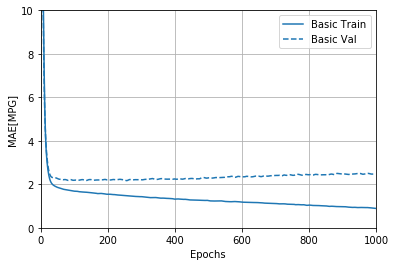

In [133]:
plotter = tfdocs.plots.HistoryPlotter(smoothing_std = 2)

plotter.plot({'Basic': history}, metric = "mae")
plt.ylim([0,10])
plt.ylabel('MAE[MPG]')
plt.show()



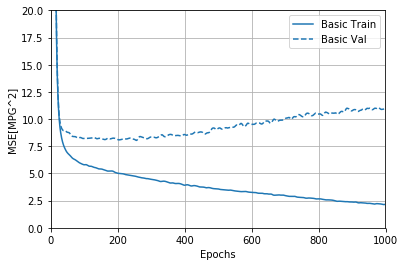

In [135]:
plotter.plot({'Basic': history}, metric = "mse")
plt.ylim([0,20])
plt.ylabel('MSE[MPG^2]')
plt.show()

In [139]:
# update the model.fit call to automatically stop training when the validation score doesn't improve. 
# EarlyStopping callback  tests a training condition for every epoch

model = build_model()

early_stop = keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 10)
early_history = model.fit(normalized_train_data, train_labels, 
                   epochs = EPOCHS, 
                   validation_split = 0.2, 
                   verbose = 0,
                   callbacks = [early_stop, tfdocs.modeling.EpochDots()])


Epoch: 0, loss:571.6360,  mae:22.6806,  mse:571.6360,  val_loss:555.6595,  val_mae:22.2915,  val_mse:555.6595,  
..........................................................

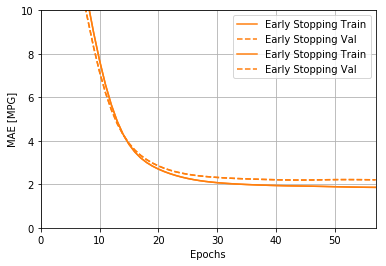

In [141]:
plotter.plot({'Early Stopping': early_history}, metric = "mae")
plt.ylim([0, 10])
plt.ylabel('MAE [MPG]')
plt.show()

In [142]:
loss, mae, mse = model.evaluate(normalized_test_data, test_labels, verbose = 2)
print("Testing set Mean Abs Error: {:5.2f} MPG".format(mae))

3/3 - 0s - loss: 6.2206 - mae: 1.9417 - mse: 6.2206
Testing set Mean Abs Error:  1.94 MPG


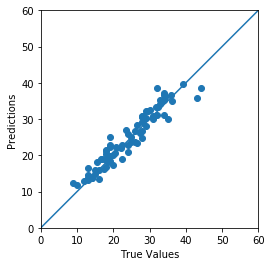

In [146]:
test_predictions = model.predict(normalized_test_data).flatten()

a = plt.axes(aspect = 'equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.xlim([0,60])
plt.ylim([0,60])
plt.plot([0,60], [0,60])
plt.show()

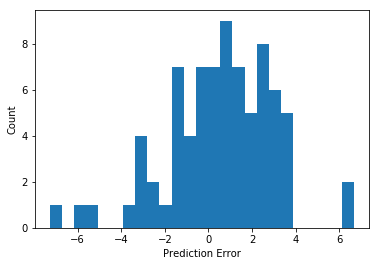

In [147]:
error = test_predictions - test_labels
plt.hist(error, bins = 25)
plt.xlabel("Prediction Error")
plt.ylabel("Count")
plt.show()

This tutorial was taken from TensorFlow Core:
https://www.tensorflow.org/tutorials/keras/regression